# Random Forest Regressor

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda, Inc.| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.13.1
Pandas Version: 0.20.3


In [ ]:
import sys 
sys.path.append('../modules')
from decision_tree_regressor import decision_tree_regressor
import collections
import pandas as pd
import numpy as np

class random_forest_regressor:
    
    def __init__(self, n_trees = 10, max_depth=None, n_features='sqrt', mode='rfnode', seed=None, criteria='std'):
        """
        Random Forest Regressor uses bootstrapping and column randomization
        to generate n_trees different datasets and then applies a decision 
        tree to each dataset. The final prediction is an ensemble of all created trees.
        ---
        Params:
        n_trees (int): number of bootstrapped trees to grow for ensembling
        max_depth (int): maximum number of splits to make in the tree
        mode: If mode='rfnode' the column randomization happens at each node. Otherwise
              the tree will assume all input columns are valid choices and randomize at
              a "per tree" level.
        n_features: The number of columns to include in the models. Only applies if
                    mode='rfnode.' Otherwise n_features = number of columns in data.
                    Options: numeric value (e.g. 4 => 4 columns used)
                             "sqrt" (square root of the number of cols in input data)
                             "div3" (number of input cols divided by 3)
        criteria: Options are "std" (standard deviation) and "mae" (absolute error from mean). 
                  This choice decides how the tree will be optimized. Default: "std"
        seed: Random seed to allow for reproducibility.
        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.n_features = n_features
        self.tree_filter_pairs = []
        self.mode = mode
        self.criteria = criteria
        if seed:
            self._seed = seed
            np.random.seed(seed)
        
    def find_number_of_columns(self, X):
        """
        Uses the user input for n_features to decide how many columns should
        be included in each model. Uses the shape of X to decide the final number
        if 'sqrt' is called. 
        ---
        Input: X (array, dataframe, or series)
        """
        if isinstance(self.n_features, int):
            return self.n_features
        if self.n_features == 'sqrt':
            return int(np.sqrt(X.shape[1])+0.5)
        if self.n_features == 'div3':
            return int(X.shape[1]/3+0.5)
        else:
            raise ValueError("Invalid n_features selection")
    
    def get_bagged_data(self, X, y):
        """
        Chooses random rows to populate a bootstrapped dataset, with replacement.
        Maintains the correlation between X and y
        ---
        Input: X, y (arrays)
        Outputs: randomized X,y (arrays)
        """
        index = np.random.choice(np.arange(len(X)),len(X))
        return X[index], y[index]
    
    def randomize_columns(self,X):
        """
        Chooses a set of columns to keep from the input data. These are
        randomly drawn, according the number requested by the user. The data
        is filtered and only the allowed columns are returned, along with the
        filter. 
        ---
        Input: X (array)
        Output: filtered_X (array), filter (array)
        """
        num_col = self.find_number_of_columns(X)
        filt = np.random.choice(np.arange(0,X.shape[1]),num_col,replace=False)
        filtered_X = self.apply_filter(X, filt)
        return filtered_X, filt
    
    def apply_filter(self, X, filt):
        """
        Given X and a filter, only the columns matching the index values
        in filter are returned.
        ---
        Input: X (array), filter (array of column IDs)
        Output: filtered_X (array)
        """
        filtered_X = X.T[filt]
        return filtered_X.T
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x)
    
    def fit(self, X, y):
        """
        Generates the bootstrapped data, decides which column to keep,
        and then uses the decision tree class to build a model on each 
        bootstrapped and column-randomized dataset. Each tree is stored 
        as part of the model for later use, along with the appropriate
        filter - which is needed to filter new data for use with the model.
        ---
        Input: X, y (arrays, dataframe, or series)
        """
        X = self.pandas_to_numpy(X)
        y = self.pandas_to_numpy(y)
        try:
            self.base_filt = [x for x in range(X.shape[1])]
        except IndexError:
            self.base_filt = [0]
        for _ in range(self.n_trees):
            filt = self.base_filt
            bagX, bagy = self.get_bagged_data(X,y)
            if self.mode == 'rftree':
                bagX, filt = self.randomize_columns(bagX)
            new_tree = decision_tree_regressor(self.max_depth, mode=self.mode, 
                                               n_features=self.n_features, criteria=self.criteria)
            new_tree.fit(bagX, bagy)
            self.tree_filter_pairs.append((new_tree, filt))
    
    def predict(self, X):
        """
        Uses the list of tree models built in the fit, doing a predict with each
        model. The associated filter is applied to X, so the model sees the columns
        it has learned about. The final prediction uses the mode of all the trees 
        predictions.
        ---
        Input: X (array, dataframe, or series)
        Output: Class ID (int)
        """
        X = self.pandas_to_numpy(X)
        self.predicts = []
        for tree, filt in self.tree_filter_pairs:
            filtered_X = self.apply_filter(X, filt)
            self.predicts.append(tree.predict(filtered_X))
        self.pred_by_row = np.array(self.predicts).T
        
        ensemble_predict = []
        for row in self.pred_by_row:
            ensemble_predict.append(np.mean(row))
        return ensemble_predict
    
    def score(self, X, y):
        """
        Uses the predict method to measure the (negative)
        mean squared error of the model.
        ---
        In: X (list or array), feature matrix; y (list or array) labels
        Out: negative mean squared error (float)
        """
        pred = self.predict(X)
        return -1.* np.mean((np.array(pred)-np.array(y))**2)

# Let's try it out with a dataset

In [2]:
def get_data():
    x = np.linspace(-10,10,300)
    y = np.sin(x)
    return x, y

In [3]:
X,y = get_data()

In [4]:
from data_splitting import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [5]:
rf = random_forest_regressor(n_trees=25, n_features='sqrt', mode='rfnode', seed=42)
rf.fit(X_train, y_train)

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Make sure each node is getting randomized properly in rfnode mode.

In [8]:
for tr in rf.tree_filter_pairs:
    print(tr[0].tree.filt)        

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [9]:
rf.score(X_test,y_test)

0.48319404857070697

In [10]:
mse = []
for n in range(1,100,10):
    rf = random_forest_regressor(n_trees=n, mode='rfnode')
    rf.fit(X_train, y_train)
    mse.append(rf.score(X_test, y_test))

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


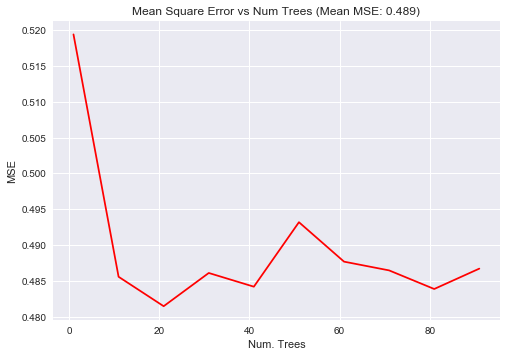

In [13]:
plt.plot(range(1,100,10),mse,'r')
plt.xlabel("Num. Trees")
plt.ylabel("MSE")
plt.title("Mean Square Error vs Num Trees (Mean MSE: %.3f)"%round(np.mean(mse),3));

# Now let's play with some more complicated data

In [26]:
from sklearn.datasets import load_boston
X = load_boston().data
y = load_boston().target

In [15]:
from data_splitting import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [16]:
rf = random_forest_regressor(n_trees=10, mode='rfnode')
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


22.151810309307486

In [19]:
mse = []
for n in range(1,100,10):
    rf = random_forest_regressor(n_trees=n, mode='rfnode', seed=42)
    rf.fit(X_train, y_train)
    mse.append(rf.score(X_test, y_test))

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


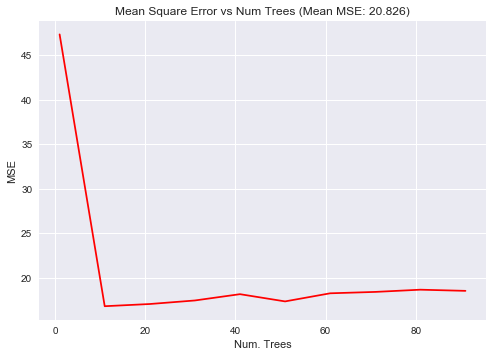

In [22]:
plt.plot(range(1,100,10),mse,'r')
plt.xlabel("Num. Trees")
plt.ylabel("MSE")
plt.title("Mean Square Error vs Num Trees (Mean MSE: %.3f)"%round(np.mean(mse),3));

# Now let's look at a few trees to see whether they're all being built the same way.

In [27]:
from data_splitting import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [28]:
rf = random_forest_regressor(max_depth=5,  n_trees=5, n_features='sqrt', mode='rfnode')
rf.fit(X_train, y_train)

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [29]:
for i, tree in enumerate(rf.tree_filter_pairs):
    print("--- Tree %i ---"%i,"\n")
    tree[0].print_tree()
    print("\n\n")

--- Tree 0 --- 

Column 10 : 20.1? 
--- True:  Column 7 : 1.3861? 
------ True:  Column 6 : 70.6? 
--------- True:  Column 0 : 7.05042? 
------------ True:  Column 7 : 1.9784? 
--------------- True:  14.0476190476
--------------- False:  11.6588235294
------------ False:  Column 7 : 3.7872? 
--------------- True:  14.525
--------------- False:  18.208
--------- False:  Column 1 : 75.0? 
------------ True:  Column 9 : 469.0? 
--------------- True:  18.9
--------------- False:  18.2
------------ False:  Column 9 : 273.0? 
--------------- True:  21.4
--------------- False:  19.5375
------ False:  Column 12 : 12.13? 
--------- True:  Column 4 : 0.668? 
------------ True:  Column 7 : 1.3163? 
--------------- True:  15.0
--------------- False:  13.8
------------ False:  27.9
--------- False:  50.0
--- False:  Column 12 : 7.14? 
------ True:  Column 4 : 0.871? 
--------- True:  Column 5 : 6.51? 
------------ True:  23.3
------------ False:  Column 0 : 2.15505? 
--------------- True:  14.66666